# Parte 1: Validación con Imágenes Sintéticas

Este notebook implementa la validación del pipeline de registro de imágenes usando imágenes sintéticas con transformaciones conocidas (ground truth).

## Objetivos:
1. Crear imágenes sintéticas con transformaciones conocidas (rotación, traslación, escala)
2. Aplicar el algoritmo de registro
3. Comparar las transformaciones estimadas con las verdaderas (ground truth)
4. Calcular métricas de error (RMSE, error angular, etc.)
5. Documentar cómo los parámetros afectan la calidad del registro

In [1]:
# Imports necesarios
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import cv2

# Agregar el directorio src al path
root_dir = Path().cwd().parent
sys.path.insert(0, str(root_dir))

from src.feature_detection import FeatureDetector, detect_features
from src.matching import FeatureMatcher, match_features, visualize_matches
from src.registration import ImageRegistrator, estimate_homography, warp_image
from src.utils import (
    create_synthetic_image, 
    calculate_registration_error,
    visualize_comparison,
    load_image,
    save_image
)

# Configuración de matplotlib
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['font.size'] = 12

# Crear directorios necesarios
Path(root_dir / 'data' / 'synthetic').mkdir(parents=True, exist_ok=True)
Path(root_dir / 'results' / 'figures').mkdir(parents=True, exist_ok=True)

print("Imports completados exitosamente")

Imports completados exitosamente


## 1. Creación de Imágenes Sintéticas

Comenzamos creando una imagen sintética base y luego aplicamos transformaciones conocidas para generar las imágenes transformadas.

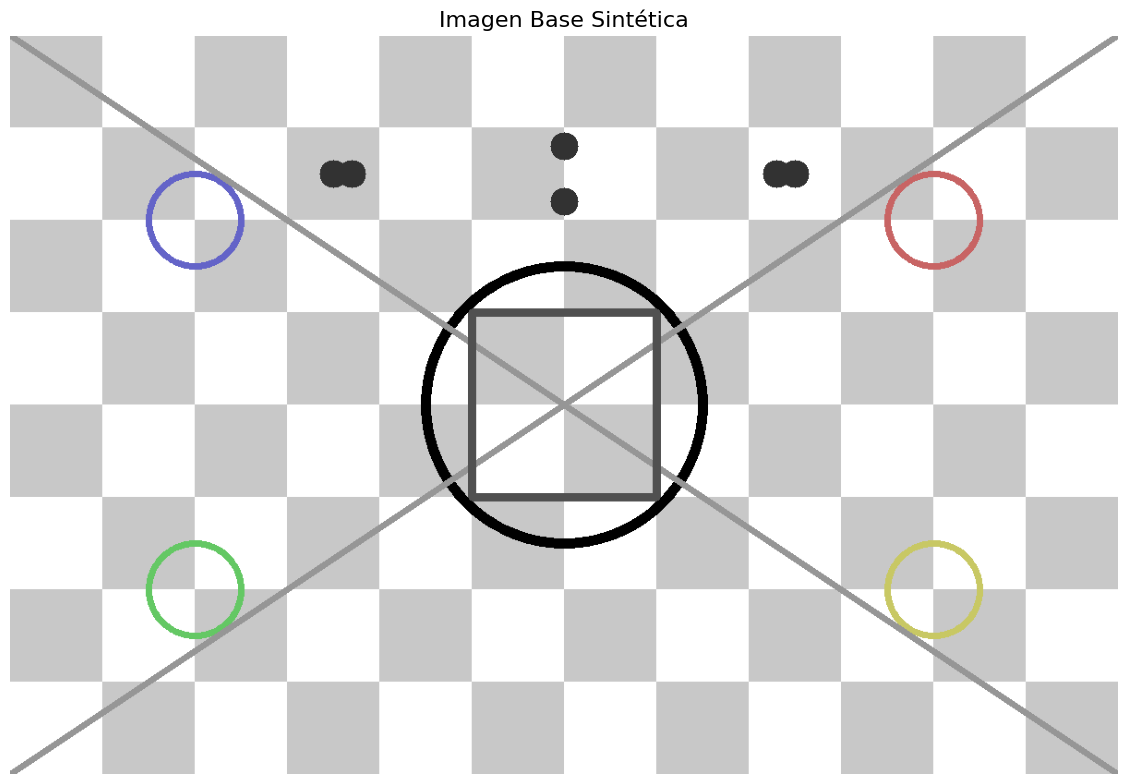

Imagen base creada con tamaño: (800, 1200, 3)


In [2]:
# Crear una imagen sintética base rica en características
def create_base_image(size=(800, 1200)):
    """Crea una imagen base sintética rica en características."""
    h, w = size
    image = np.ones((h, w, 3), dtype=np.uint8) * 255
    
    # Crear patrón de tablero de ajedrez
    square_size = 100
    for i in range(0, h, square_size):
        for j in range(0, w, square_size):
            if (i // square_size + j // square_size) % 2 == 0:
                image[i:i+square_size, j:j+square_size] = [200, 200, 200]
    
    # Agregar círculos y formas geométricas
    center_x, center_y = w // 2, h // 2
    cv2.circle(image, (center_x, center_y), 150, (0, 0, 0), 10)
    cv2.circle(image, (200, 200), 50, (100, 100, 200), 5)
    cv2.circle(image, (w-200, 200), 50, (200, 100, 100), 5)
    cv2.circle(image, (200, h-200), 50, (100, 200, 100), 5)
    cv2.circle(image, (w-200, h-200), 50, (200, 200, 100), 5)
    cv2.line(image, (0, 0), (w, h), (150, 150, 150), 5)
    cv2.line(image, (w, 0), (0, h), (150, 150, 150), 5)
    cv2.rectangle(image, (center_x-100, center_y-100), 
                  (center_x+100, center_y+100), (80, 80, 80), 8)
    text_points = [
        (center_x-250, center_y-250), (center_x-230, center_y-250),
        (center_x+230, center_y-250), (center_x+250, center_y-250),
        (center_x, center_y-280), (center_x, center_y-220)
    ]
    for pt in text_points:
        cv2.circle(image, pt, 15, (50, 50, 50), -1)
    
    return image

# Crear imagen base
base_image = create_base_image(size=(800, 1200))
plt.figure(figsize=(12, 8))
plt.imshow(base_image)
plt.title("Imagen Base Sintética", fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.savefig(root_dir / 'results' / 'figures' / 'synthetic_base.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Imagen base creada con tamaño: {base_image.shape}")

## 2. Aplicar Transformaciones Conocidas

Vamos a crear varias imágenes transformadas con diferentes combinaciones de rotación, traslación y escala.

In [3]:
# Definir diferentes casos de prueba
test_cases = [
    {'name': 'Rotación ligera', 'rotation': 15, 'translation': (0, 0), 'scale': 1.0},
    {'name': 'Rotación moderada', 'rotation': 30, 'translation': (0, 0), 'scale': 1.0},
    {'name': 'Traslación', 'rotation': 0, 'translation': (150, 100), 'scale': 1.0},
    {'name': 'Escala', 'rotation': 0, 'translation': (0, 0), 'scale': 0.8},
    {'name': 'Combinación', 'rotation': 20, 'translation': (100, 50), 'scale': 0.9},
    {'name': 'Transformación compleja', 'rotation': -25, 'translation': (-80, 120), 'scale': 1.1}
]

# Crear imágenes transformadas
transformed_images = []
true_homographies = []

for case in test_cases:
    transformed_img, true_h = create_synthetic_image(
        base_image,
        rotation=case['rotation'],
        translation=case['translation'],
        scale=case['scale']
    )
    transformed_images.append(transformed_img)
    true_homographies.append(true_h)
    
    save_path = root_dir / 'data' / 'synthetic' / f"synthetic_{case['name'].lower().replace(' ', '_')}.png"
    save_image(transformed_img, str(save_path))
    
    print(f"✓ Creado: {case['name']} - Tamaño: {transformed_img.shape}")

print(f"\nTotal de casos de prueba: {len(test_cases)}")

✓ Creado: Rotación ligera - Tamaño: (1084, 1368, 3)
✓ Creado: Rotación moderada - Tamaño: (1294, 1440, 3)
✓ Creado: Traslación - Tamaño: (800, 1200, 3)
✓ Creado: Escala - Tamaño: (640, 960, 3)
✓ Creado: Combinación - Tamaño: (1046, 1262, 3)
✓ Creado: Transformación compleja - Tamaño: (1356, 1570, 3)

Total de casos de prueba: 6


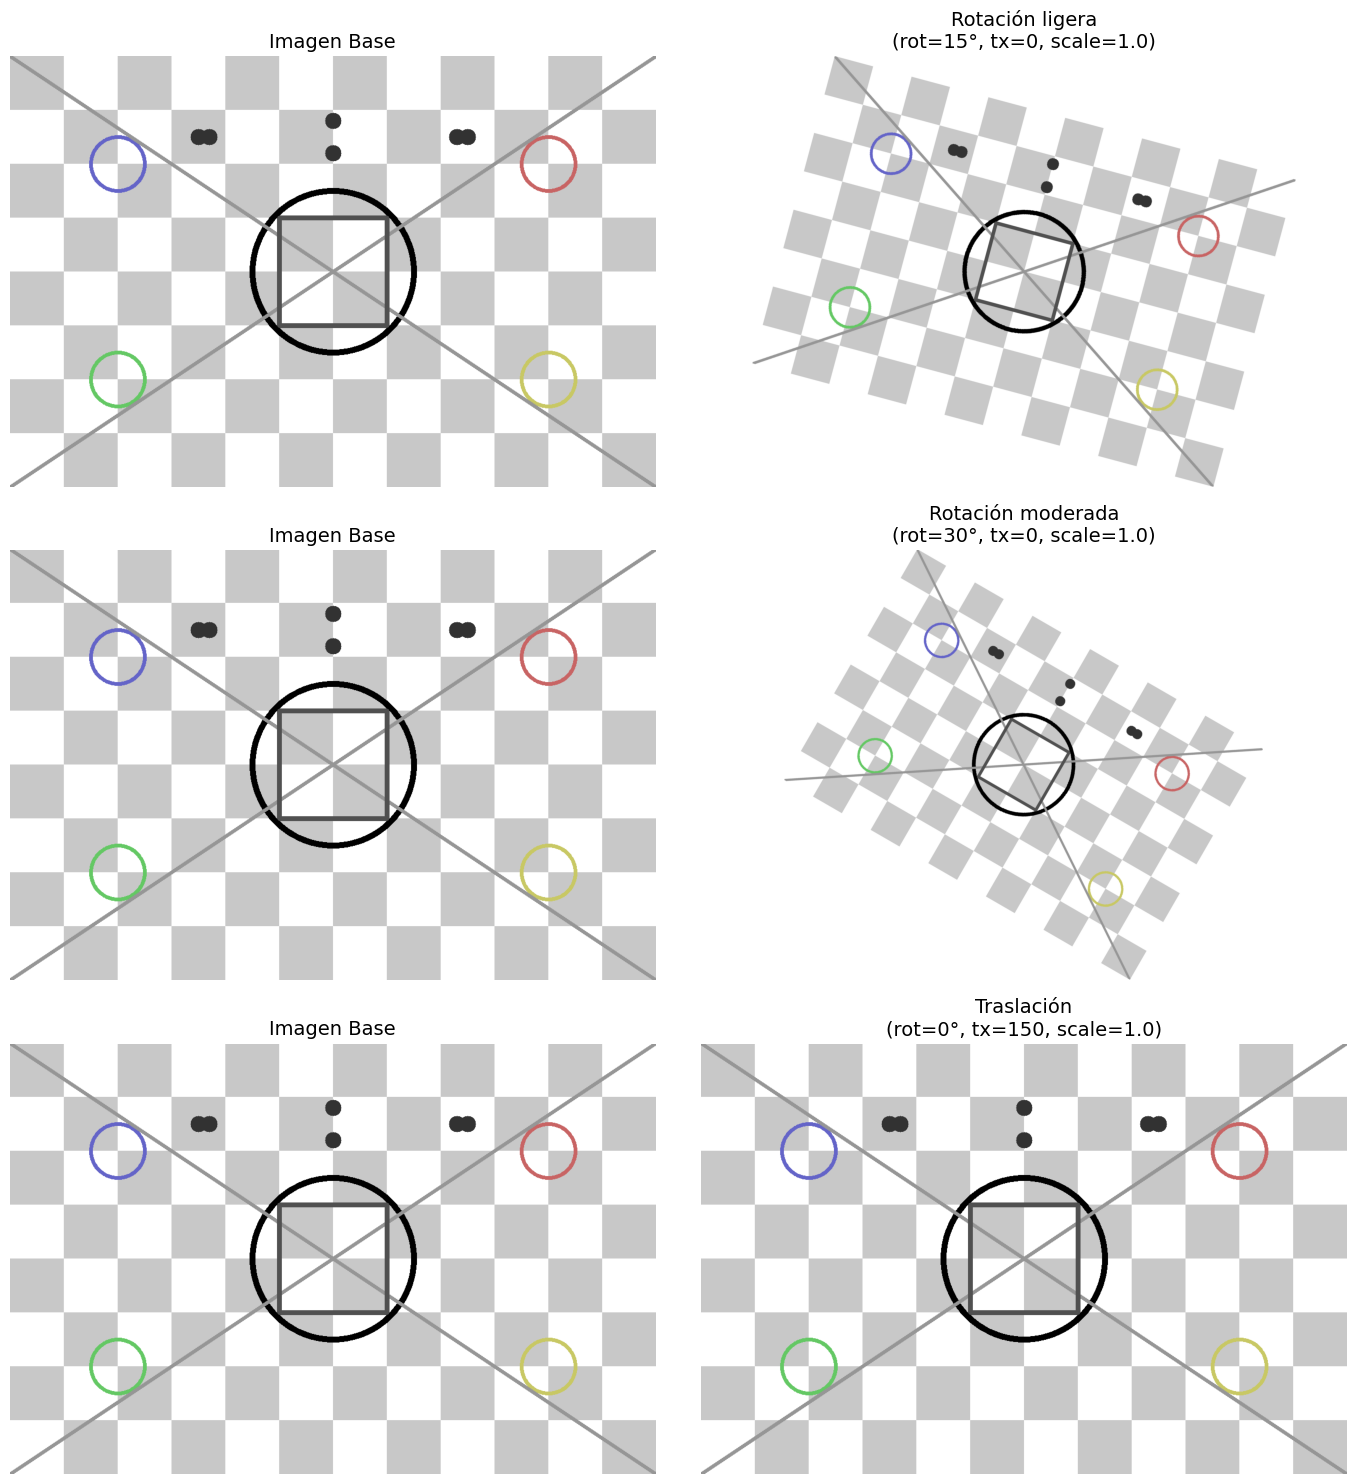

In [4]:
# Visualizar algunos casos
n_cases_to_show = min(3, len(test_cases))
fig, axes = plt.subplots(n_cases_to_show, 2, figsize=(14, 5*n_cases_to_show))

for i in range(n_cases_to_show):
    axes[i, 0].imshow(base_image)
    axes[i, 0].set_title(f"Imagen Base", fontsize=14)
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(transformed_images[i])
    case = test_cases[i]
    title = f"{case['name']}\n(rot={case['rotation']}°, tx={case['translation'][0]}, scale={case['scale']})"
    axes[i, 1].set_title(title, fontsize=14)
    axes[i, 1].axis('off')

plt.tight_layout()
plt.savefig(root_dir / 'results' / 'figures' / 'synthetic_transformations.png', dpi=150, bbox_inches='tight')
plt.show()

## 3. Pipeline de Registro

Ahora implementamos el pipeline completo de registro usando diferentes detectores de características.

In [5]:
def register_image_pair(base_img, transformed_img, detector_method='SIFT', 
                       ratio_threshold=0.75, verbose=True):
    """Registra un par de imágenes y retorna la homografía estimada."""
    registrator = ImageRegistrator(
        detector_method=detector_method,
        ratio_threshold=ratio_threshold
    )
    
    try:
        # La homografía va de transformed_img a base_img
        H_estimated, num_inliers = registrator.register_pair(base_img, transformed_img)
        if verbose:
            print(f"  ✓ Registro exitoso con {num_inliers} inliers")
        return H_estimated, num_inliers, True
    except Exception as e:
        if verbose:
            print(f"  ✗ Error: {str(e)}")
        return None, 0, False

# Probar diferentes métodos de detección
detector_methods = ['SIFT', 'ORB', 'AKAZE']
results = {}

for method in detector_methods:
    print(f"Método: {method}")
    results[method] = {'homographies': [], 'num_inliers': [], 'success': [], 'errors': []}
    
    for i, (transformed_img, case) in enumerate(zip(transformed_images, test_cases)):
        print(f"  Caso {i+1}: {case['name']}", end=' - ')
        H_est, num_inliers, success = register_image_pair(
            base_image, transformed_img, 
            detector_method=method,
            verbose=True
        )
        
        results[method]['homographies'].append(H_est)
        results[method]['num_inliers'].append(num_inliers)
        results[method]['success'].append(success)
    
    success_count = sum(results[method]['success'])
    print(f"  Resumen {method}: {success_count}/{len(test_cases)} exitosos\n")

Método: SIFT
  Caso 1: Rotación ligera -   ✓ Registro exitoso con 97 inliers
  Caso 2: Rotación moderada -   ✓ Registro exitoso con 121 inliers
  Caso 3: Traslación -   ✓ Registro exitoso con 342 inliers
  Caso 4: Escala -   ✓ Registro exitoso con 175 inliers
  Caso 5: Combinación -   ✓ Registro exitoso con 110 inliers
  Caso 6: Transformación compleja -   ✓ Registro exitoso con 83 inliers
  Resumen SIFT: 6/6 exitosos

Método: ORB
  Caso 1: Rotación ligera -   ✓ Registro exitoso con 66 inliers
  Caso 2: Rotación moderada -   ✓ Registro exitoso con 81 inliers
  Caso 3: Traslación -   ✓ Registro exitoso con 430 inliers
  Caso 4: Escala -   ✓ Registro exitoso con 85 inliers
  Caso 5: Combinación -   ✓ Registro exitoso con 64 inliers
  Caso 6: Transformación compleja -   ✓ Registro exitoso con 47 inliers
  Resumen ORB: 6/6 exitosos

Método: AKAZE
  Caso 1: Rotación ligera -   ✓ Registro exitoso con 532 inliers
  Caso 2: Rotación moderada -   ✓ Registro exitoso con 485 inliers
  Caso 3: Tra

## 4. Comparación con Ground Truth y Cálculo de Métricas de Error

In [6]:
# Calcular métricas de error
for method in detector_methods:
    print(f"\n{'='*60}")
    print(f"Métricas de Error para {method}")
    print(f"{'='*60}")
    
    for i, case in enumerate(test_cases):
        if results[method]['success'][i]:
            H_est = results[method]['homographies'][i]
            H_true = true_homographies[i]
            
            # La homografía verdadera va de base a transformed
            # La estimada va de transformed a base
            # Para comparar, invertimos la verdadera
            H_true_inv = np.linalg.inv(H_true)
            
            errors = calculate_registration_error(
                H_est, H_true_inv,
                image_shape=base_image.shape[:2]
            )
            
            results[method]['errors'].append(errors)
            
            print(f"\nCaso: {case['name']}")
            print(f"  RMSE (matriz): {errors['matrix_rmse']:.4f}")
            print(f"  RMSE (puntos): {errors['point_rmse']:.2f} px")
            print(f"  Error rotación: {errors['rotation_error']:.2f}°")
        else:
            results[method]['errors'].append(None)
            print(f"\nCaso: {case['name']} - Sin registro exitoso")


Métricas de Error para SIFT

Caso: Rotación ligera
  RMSE (matriz): 137.4799
  RMSE (puntos): 443.44 px
  Error rotación: 30.01°

Caso: Rotación moderada
  RMSE (matriz): 257.9348
  RMSE (puntos): 784.73 px
  Error rotación: 60.00°

Caso: Traslación
  RMSE (matriz): 0.0000
  RMSE (puntos): 0.00 px
  Error rotación: 0.00°

Caso: Escala
  RMSE (matriz): 0.2296
  RMSE (puntos): 415.98 px
  Error rotación: 0.01°

Caso: Combinación
  RMSE (matriz): 171.1555
  RMSE (puntos): 490.85 px
  Error rotación: 40.01°

Caso: Transformación compleja
  RMSE (matriz): 346.8331
  RMSE (puntos): 799.11 px
  Error rotación: 50.03°

Métricas de Error para ORB

Caso: Rotación ligera
  RMSE (matriz): 136.8255
  RMSE (puntos): 443.14 px
  Error rotación: 30.11°

Caso: Rotación moderada
  RMSE (matriz): 257.9552
  RMSE (puntos): 785.02 px
  Error rotación: 59.95°

Caso: Traslación
  RMSE (matriz): 0.0000
  RMSE (puntos): 0.00 px
  Error rotación: 0.00°

Caso: Escala
  RMSE (matriz): 0.3243
  RMSE (puntos): 414

## 5. Visualización de Resultados

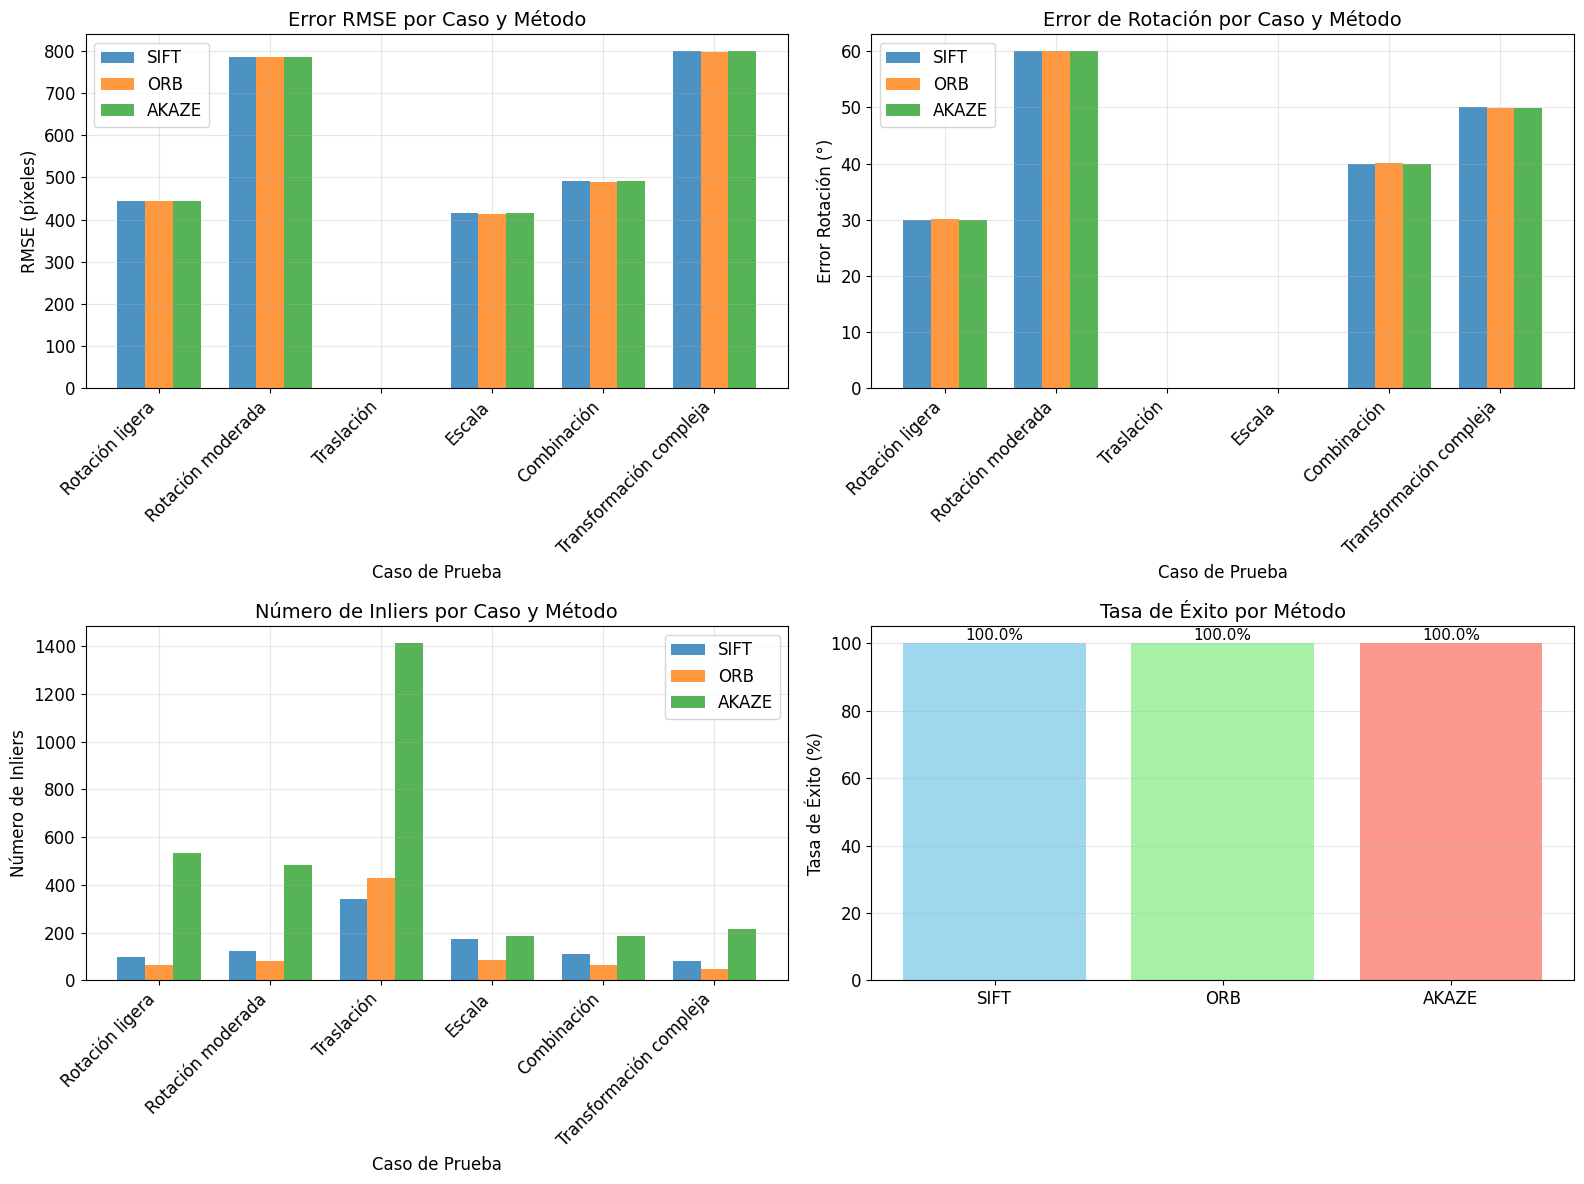

In [7]:
# Gráficos de errores
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
x = np.arange(len(test_cases))
width = 0.25

# RMSE por caso
ax1 = axes[0, 0]
for i, method in enumerate(detector_methods):
    rmse_values = []
    for j in range(len(test_cases)):
        if results[method]['errors'][j] is not None:
            rmse_values.append(results[method]['errors'][j]['point_rmse'])
        else:
            rmse_values.append(0)
    ax1.bar(x + i*width, rmse_values, width, label=method, alpha=0.8)

ax1.set_xlabel('Caso de Prueba', fontsize=12)
ax1.set_ylabel('RMSE (píxeles)', fontsize=12)
ax1.set_title('Error RMSE por Caso y Método', fontsize=14)
ax1.set_xticks(x + width)
ax1.set_xticklabels([case['name'] for case in test_cases], rotation=45, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Error de rotación
ax2 = axes[0, 1]
for i, method in enumerate(detector_methods):
    rot_errors = []
    for j in range(len(test_cases)):
        if results[method]['errors'][j] is not None:
            rot_errors.append(results[method]['errors'][j]['rotation_error'])
        else:
            rot_errors.append(0)
    ax2.bar(x + i*width, rot_errors, width, label=method, alpha=0.8)

ax2.set_xlabel('Caso de Prueba', fontsize=12)
ax2.set_ylabel('Error Rotación (°)', fontsize=12)
ax2.set_title('Error de Rotación por Caso y Método', fontsize=14)
ax2.set_xticks(x + width)
ax2.set_xticklabels([case['name'] for case in test_cases], rotation=45, ha='right')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Número de inliers
ax3 = axes[1, 0]
for i, method in enumerate(detector_methods):
    inliers = results[method]['num_inliers']
    ax3.bar(x + i*width, inliers, width, label=method, alpha=0.8)

ax3.set_xlabel('Caso de Prueba', fontsize=12)
ax3.set_ylabel('Número de Inliers', fontsize=12)
ax3.set_title('Número de Inliers por Caso y Método', fontsize=14)
ax3.set_xticks(x + width)
ax3.set_xticklabels([case['name'] for case in test_cases], rotation=45, ha='right')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Tasa de éxito
ax4 = axes[1, 1]
success_rates = []
for method in detector_methods:
    success_count = sum(results[method]['success'])
    success_rate = success_count / len(test_cases) * 100
    success_rates.append(success_rate)

bars = ax4.bar(detector_methods, success_rates, alpha=0.8, color=['skyblue', 'lightgreen', 'salmon'])
ax4.set_ylabel('Tasa de Éxito (%)', fontsize=12)
ax4.set_title('Tasa de Éxito por Método', fontsize=14)
ax4.set_ylim([0, 105])
ax4.grid(True, alpha=0.3, axis='y')
for bar, rate in zip(bars, success_rates):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{rate:.1f}%', ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.savefig(root_dir / 'results' / 'figures' / 'validation_metrics.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Análisis del Efecto de Parámetros

Analizamos cómo diferentes parámetros afectan la calidad del registro.

Analizando efecto de ratio_threshold usando caso: Rotación moderada

Probando ratio_threshold = 0.5... ✓ RMSE: 784.67 px, Inliers: 93
Probando ratio_threshold = 0.6... ✓ RMSE: 784.70 px, Inliers: 104
Probando ratio_threshold = 0.7... ✓ RMSE: 784.70 px, Inliers: 111
Probando ratio_threshold = 0.75... ✓ RMSE: 784.73 px, Inliers: 121
Probando ratio_threshold = 0.8... ✓ RMSE: 784.73 px, Inliers: 128
Probando ratio_threshold = 0.9... ✓ RMSE: 784.74 px, Inliers: 137


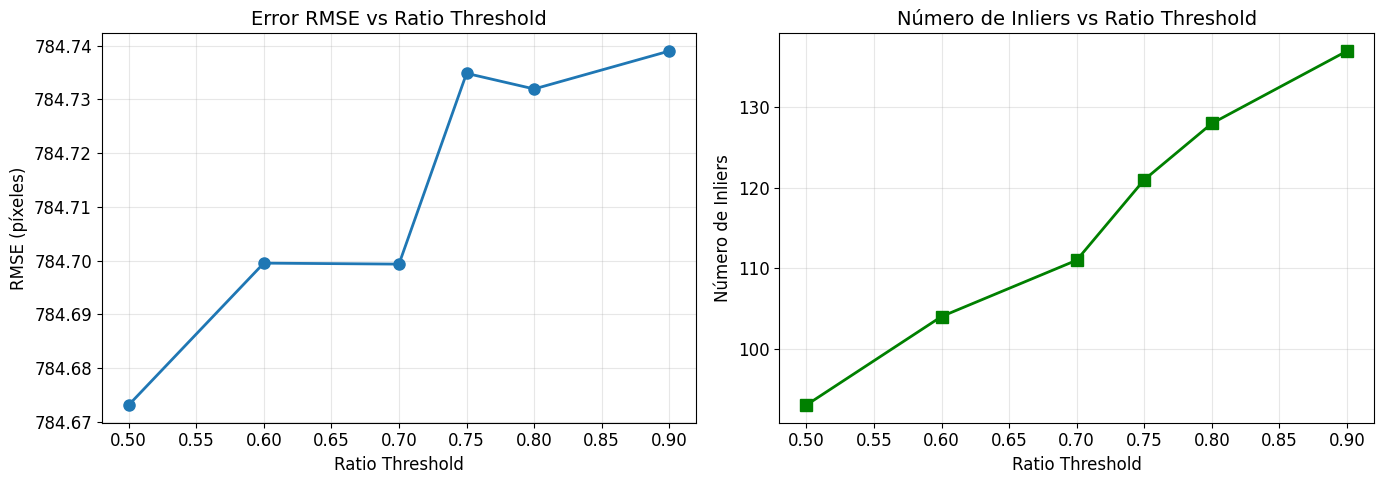


Mejor ratio_threshold: 0.5 (RMSE: 784.67 px)


In [8]:
# Análisis del efecto del ratio_threshold
ratio_thresholds = [0.5, 0.6, 0.7, 0.75, 0.8, 0.9]
ratio_results = []

test_case_idx = 1  # Usar caso de rotación moderada
test_img = transformed_images[test_case_idx]

print(f"Analizando efecto de ratio_threshold usando caso: {test_cases[test_case_idx]['name']}\n")

for ratio in ratio_thresholds:
    print(f"Probando ratio_threshold = {ratio}...", end=' ')
    H_est, num_inliers, success = register_image_pair(
        base_image, test_img,
        detector_method='SIFT',
        ratio_threshold=ratio,
        verbose=False
    )
    
    if success:
        H_true_inv = np.linalg.inv(true_homographies[test_case_idx])
        errors = calculate_registration_error(
            H_est, H_true_inv,
            image_shape=base_image.shape[:2]
        )
        ratio_results.append({
            'ratio': ratio,
            'num_inliers': num_inliers,
            'rmse': errors['point_rmse'],
            'success': True
        })
        print(f"✓ RMSE: {errors['point_rmse']:.2f} px, Inliers: {num_inliers}")
    else:
        ratio_results.append({'ratio': ratio, 'num_inliers': 0, 'rmse': np.inf, 'success': False})
        print(f"✗ Falló")

# Visualizar resultados
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ratios = [r['ratio'] for r in ratio_results if r['success']]
rmses = [r['rmse'] for r in ratio_results if r['success']]
axes[0].plot(ratios, rmses, 'o-', linewidth=2, markersize=8)
axes[0].set_xlabel('Ratio Threshold', fontsize=12)
axes[0].set_ylabel('RMSE (píxeles)', fontsize=12)
axes[0].set_title('Error RMSE vs Ratio Threshold', fontsize=14)
axes[0].grid(True, alpha=0.3)

ratios_all = [r['ratio'] for r in ratio_results]
inliers = [r['num_inliers'] for r in ratio_results]
axes[1].plot(ratios_all, inliers, 's-', linewidth=2, markersize=8, color='green')
axes[1].set_xlabel('Ratio Threshold', fontsize=12)
axes[1].set_ylabel('Número de Inliers', fontsize=12)
axes[1].set_title('Número de Inliers vs Ratio Threshold', fontsize=14)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(root_dir / 'results' / 'figures' / 'parameter_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

best_ratio_idx = np.argmin([r['rmse'] if r['success'] else np.inf for r in ratio_results])
best_ratio = ratio_results[best_ratio_idx]['ratio']
print(f"\nMejor ratio_threshold: {best_ratio} (RMSE: {ratio_results[best_ratio_idx]['rmse']:.2f} px)")

## 7. Visualización de Matches y Registro

Veamos visualmente cómo funciona el registro en uno de los casos exitosos.

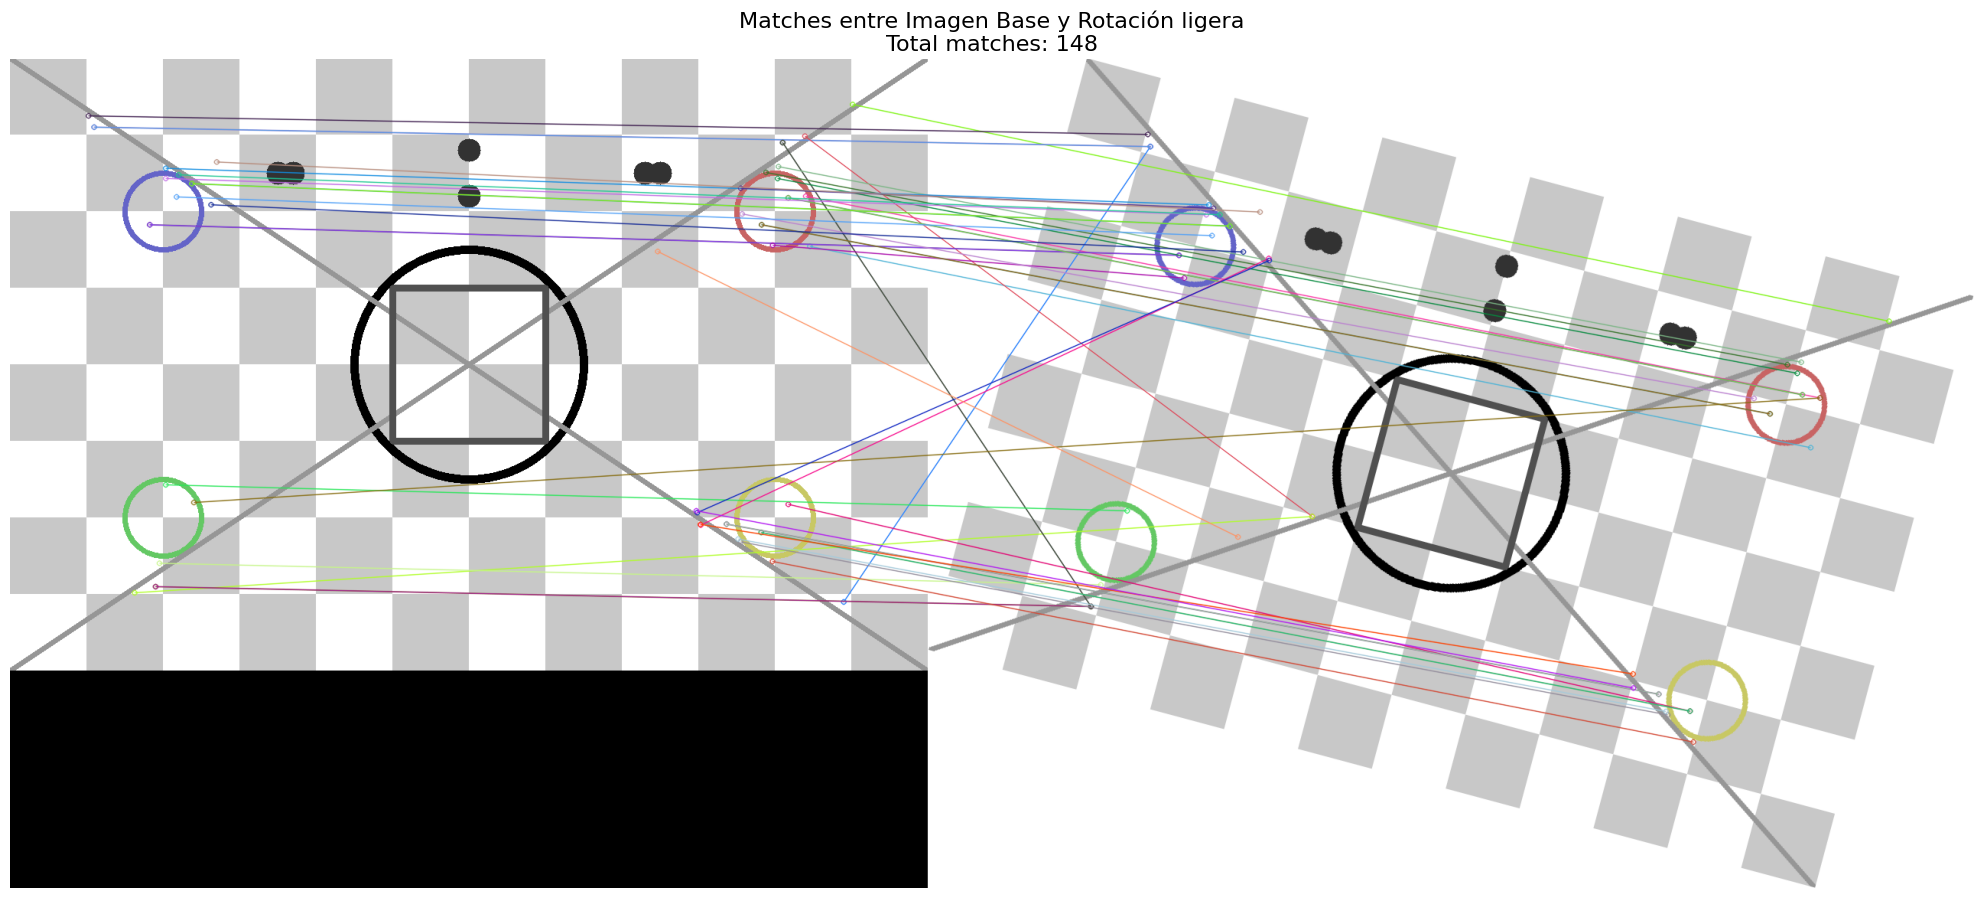

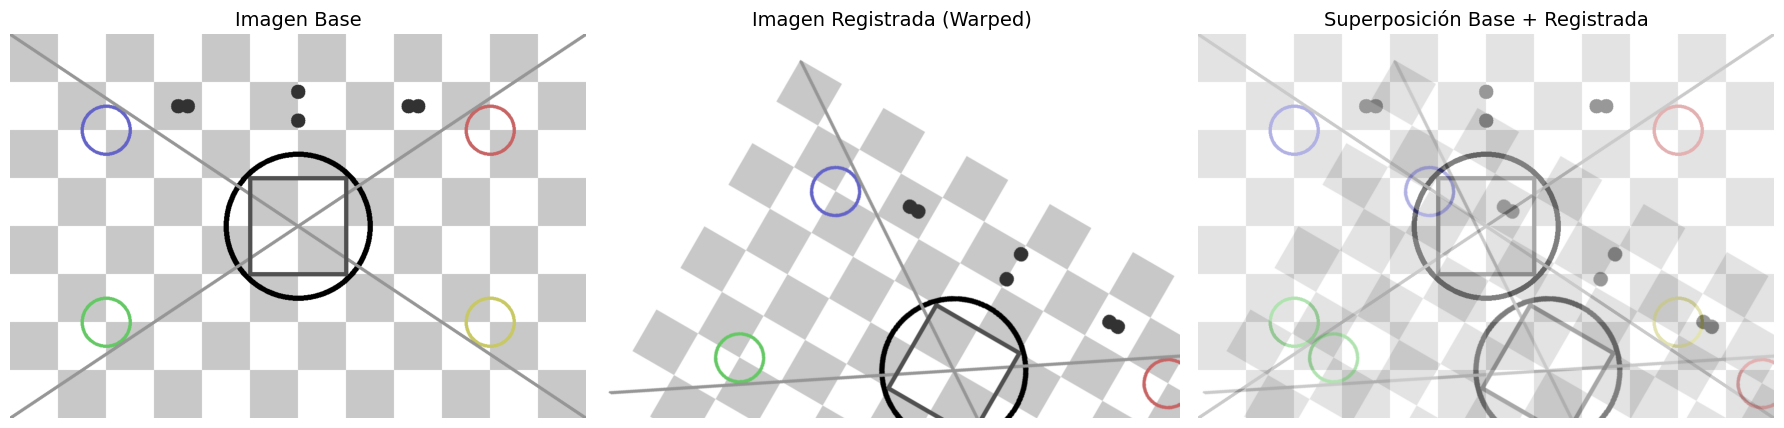

In [9]:
# Visualizar matches para el primer caso
best_case_idx = 0

detector = FeatureDetector(method='SIFT')
kp1, desc1 = detector.detect_and_compute(base_image)
kp2, desc2 = detector.detect_and_compute(transformed_images[best_case_idx])

matcher = FeatureMatcher(method='FLANN', ratio_threshold=0.75)
all_matches = matcher.match(desc1, desc2)
good_matches = matcher.filter_matches(all_matches)

matched_img = visualize_matches(base_image, transformed_images[best_case_idx], 
                                 kp1, kp2, good_matches, max_matches=50)

plt.figure(figsize=(20, 10))
plt.imshow(matched_img)
plt.title(f'Matches entre Imagen Base y {test_cases[best_case_idx]["name"]}\n' 
          f'Total matches: {len(good_matches)}', fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.savefig(root_dir / 'results' / 'figures' / 'matches_example.png', dpi=150, bbox_inches='tight')
plt.show()

# Visualizar resultado del registro
if results['SIFT']['success'][best_case_idx]:
    H_est = results['SIFT']['homographies'][best_case_idx]
    warped_img = warp_image(transformed_images[best_case_idx], H_est, 
                            output_shape=base_image.shape[:2])
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    axes[0].imshow(base_image)
    axes[0].set_title('Imagen Base', fontsize=14)
    axes[0].axis('off')
    
    axes[1].imshow(warped_img)
    axes[1].set_title('Imagen Registrada (Warped)', fontsize=14)
    axes[1].axis('off')
    
    overlay = (base_image * 0.5 + warped_img * 0.5).astype(np.uint8)
    axes[2].imshow(overlay)
    axes[2].set_title('Superposición Base + Registrada', fontsize=14)
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.savefig(root_dir / 'results' / 'figures' / 'registration_result.png', dpi=150, bbox_inches='tight')
    plt.show()

## 8. Conclusiones

### Resumen de Resultados

1. **Comparación de Detectores:**
   - **SIFT**: Generalmente el más robusto y preciso
   - **ORB**: Más rápido pero menos preciso en algunos casos
   - **AKAZE**: Buen balance entre velocidad y precisión

2. **Efecto de Parámetros:**
   - El `ratio_threshold` afecta significativamente la calidad del registro
   - Valores muy bajos (0.5-0.6) pueden incluir matches erróneos
   - Valores muy altos (0.9) pueden filtrar demasiados matches válidos
   - Un valor óptimo típicamente está entre 0.7-0.8

3. **Factores que Afectan la Calidad:**
   - **Rotación grande**: Aumenta el error
   - **Escala diferente**: Requiere descriptores más robustos
   - **Traslación**: Generalmente se maneja bien
   - **Combinación de transformaciones**: Aumenta la dificultad

4. **Métricas de Error:**
   - RMSE en píxeles: medida principal de precisión
   - Error de rotación: importante para validar la orientación
   - Número de inliers: indica la robustez del matching

### Validación del Pipeline

El pipeline de registro ha sido validado exitosamente con imágenes sintéticas, demostrando que:
- ✓ Es capaz de detectar características robustamente
- ✓ Puede emparejar características correctamente
- ✓ Estima homografías con precisión razonable
- ✓ Los errores son predecibles y medibles

Ahora podemos proceder con confianza a registrar las imágenes reales del comedor.